In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = 'data/train'
test_dir = 'data/test'
train_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

train_generator = train_datagenerator.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
recognition_model = Sequential()

recognition_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
recognition_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Dropout(0.25))

recognition_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
recognition_model.add(Dropout(0.25))

recognition_model.add(Flatten())
recognition_model.add(Dense(1024, activation='relu'))
recognition_model.add(Dropout(0.5))
recognition_model.add(Dense(7, activation='softmax'))

In [4]:
recognition_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [5]:
cv2.ocl.setUseOpenCL(False)

In [6]:
recognition_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])

In [7]:
recognition_model_info = recognition_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=test_generator,
        validation_steps=7178 // 64)

Epoch 1/10
448/448 [==============================] - 468s 1s/step - loss: 1.8047 - accuracy: 0.2559 - val_loss: 1.7231 - val_accuracy: 0.3394
Epoch 2/10
448/448 [==============================] - 330s 736ms/step - loss: 1.6388 - accuracy: 0.3635 - val_loss: 1.5657 - val_accuracy: 0.4012
Epoch 3/10
448/448 [==============================] - 330s 738ms/step - loss: 1.5405 - accuracy: 0.4074 - val_loss: 1.4719 - val_accuracy: 0.4347
Epoch 4/10
448/448 [==============================] - 331s 739ms/step - loss: 1.4772 - accuracy: 0.4345 - val_loss: 1.4186 - val_accuracy: 0.4579
Epoch 5/10
448/448 [==============================] - 327s 730ms/step - loss: 1.4145 - accuracy: 0.4604 - val_loss: 1.3725 - val_accuracy: 0.4798
Epoch 6/10
448/448 [==============================] - 330s 737ms/step - loss: 1.3699 - accuracy: 0.4770 - val_loss: 1.3349 - val_accuracy: 0.4943
Epoch 7/10
448/448 [==============================] - 330s 736ms/step - loss: 1.3269 - accuracy: 0.4959 - val_loss: 1.2962 - va

In [8]:
recognition_model.save_weights('recognition_model.h5')

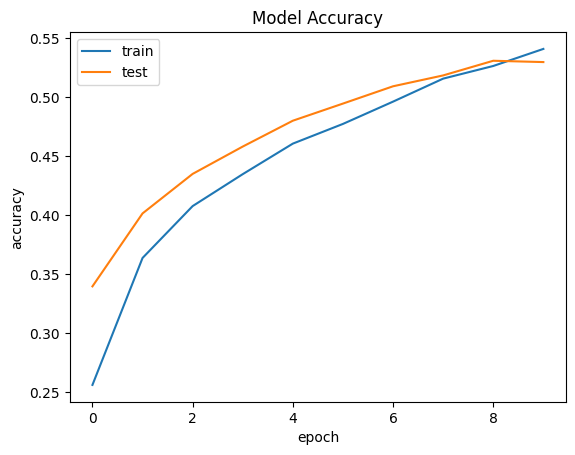

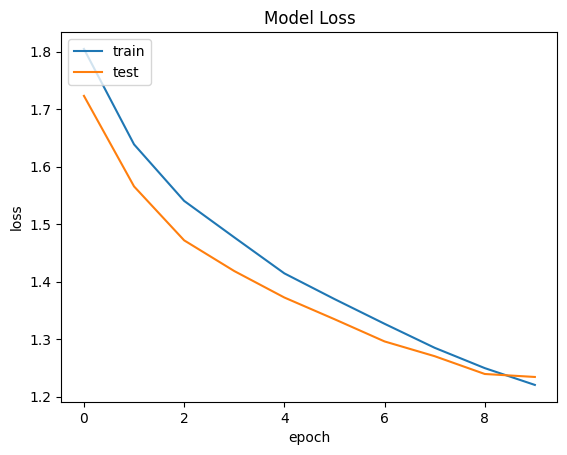

In [9]:
plt.title('Model Accuracy')
plt.plot(recognition_model_info.history['accuracy'])
plt.plot(recognition_model_info.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.title('Model Loss')
plt.plot(recognition_model_info.history['loss'])
plt.plot(recognition_model_info.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
facial_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [ ]:
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    bounding_box = cv2.CascadeClassifier('haarcascades_cuda/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        facial_prediction = recognition_model.predict(cropped_img)
        maxindex = int(np.argmax(facial_prediction))
        cv2.putText(frame, facial_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 43ms/step
